In [205]:
import numpy as np
import matplotlib.pyplot as plt
from getdist.mcsamples import loadMCSamples
from getdist import plots
from classy_sz import Class as Class_sz

In [206]:
%%time
cosmo_params = {
'omega_b': 0.02242,
'omega_cdm':  0.11933,
'H0': 67.66, # use H0 because this is what is used by the emulators.
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.9665,
'cosmo_model': 0
}

# initialize computation
classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set({
'output':' ',
'jax': 1,
})
classy_sz.compute_class_szfast()

CPU times: user 8.41 ms, sys: 16 ms, total: 24.4 ms
Wall time: 23.7 ms


In [207]:
# Define chain directory
chain_dir = r'/Users/licongxu/Work/tszpower/chains/tszpower_chain'
# chain_dir = r'/Users/licongxu/Desktop/chains/tszpower_chain'

# Load MCMC samples
ignore_row = 0.2
readsamps = loadMCSamples(chain_dir, settings={'ignore_rows':ignore_row})
p = readsamps.getParams()
print('Adding derived parameters')

# Compute sigma8 for each sample
sigma8_values = []

for i in range(len(p.ln10_10A_s)):
    logA = p.ln10_10A_s[i]
    omega_cdm = p.omega_cdm[i]
    omega_b = p.omega_b[i]
    # omega_b = 0.02242
    H0 = p.H0[i]
    n_s = p.n_s[i]
    # n_s = 0.9665
    cosmo_params = {
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'H0': H0,
        'ln10^{10}A_s': logA,
        'n_s': n_s,
        # 'cosmo_model': 0
    }

    A_s_dict = cosmo_params
    sigma8 = classy_sz.get_sigma8_and_der(params_values_dict=A_s_dict)[1]  # Compute sigma8
    sigma8_values.append(sigma8)


# Convert list to numpy array
sigma8_values = np.array(sigma8_values)

# Add derived parameters to MCMC samples
readsamps.addDerived(sigma8_values, name='sigma8', label=r'\sigma_8')
# Compute derived parameter: ln(1/A_rs)
ln_1_A_rs = np.log(1.0 / p.A_rs)

# Add derived parameter to samples
readsamps.addDerived(ln_1_A_rs, name='ln_1_A_rs', label=r'\ln(1/A_\mathrm{rs})')
print("Derived parameters added successfully.")

/Users/licongxu/Work/tszpower/chains/tszpower_chain.4.txt
/Users/licongxu/Work/tszpower/chains/tszpower_chain.1.txt
/Users/licongxu/Work/tszpower/chains/tszpower_chain.2.txt
/Users/licongxu/Work/tszpower/chains/tszpower_chain.3.txt
Removed 0.2 as burn in
Adding derived parameters
Derived parameters added successfully.


In [208]:
sigma8_values

array([0.80368083, 0.80957496, 0.81201744, ..., 0.91861048, 0.91722184,
       0.95093954])

In [209]:
p.ln10_10A_s

array([2.8739438, 2.8882074, 2.8945667, ..., 3.2361137, 3.237269 ,
       3.2713089])

In [210]:
# Compute h and Omega_m for each sample
h = p.H0 / 100.0  # Compute h
# omega_b = 0.02242  # Fixed value of omega_b
Omega_m = (p.omega_cdm + p.omega_b) / h**2  # Compute Omega_m

# Compute F = sigma8 * (Omega_m / B)^0.40 * h^-0.21
F_values = sigma8_values * (Omega_m / p.B) ** (0.40) * h ** (-0.21)

# Add F as a derived parameter
readsamps.addDerived(F_values, name='F', label=r'F = \sigma_8 (\Omega_m / B)^{0.40} h^{-0.21}')

# **Force GetDist to recognize the new parameter**
readsamps.updateBaseStatistics()

print("Derived parameter F added successfully.")


Derived parameter F added successfully.


In [211]:
Fs = readsamps.getInlineLatex('F',limit=1)
print('F: ',Fs)

F:  F = \sigma_8 (\Omega_m / B)^{0.40} h^{-0.21} = 0.4818\pm 0.0054


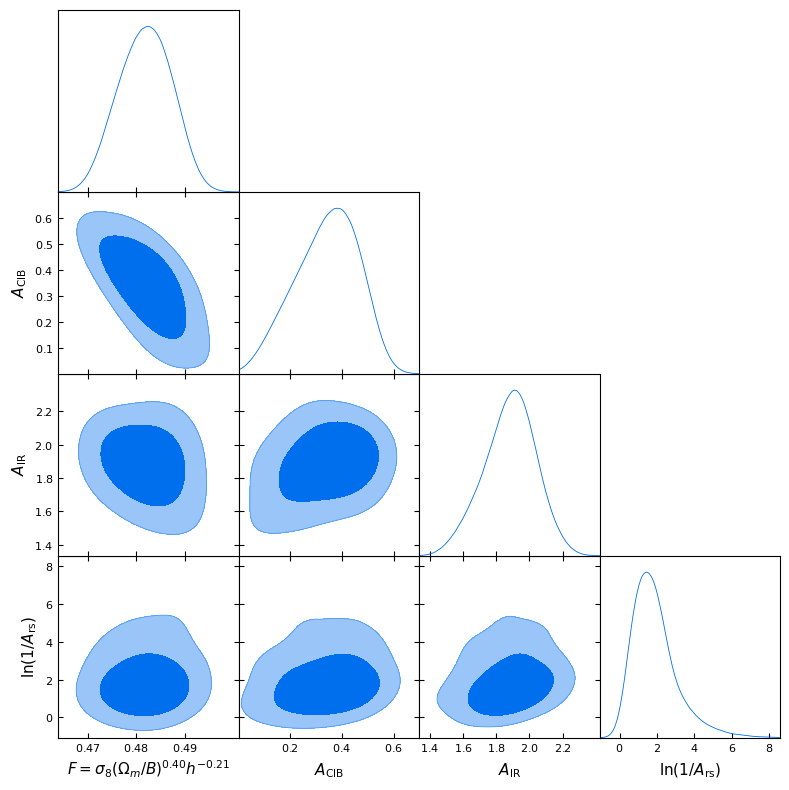

In [212]:
# Define parameters to plot
params_to_plot = ['F', 'A_cib', 'A_ir','ln_1_A_rs']

# Create a triangle plot (corner plot)
g = plots.get_subplot_plotter()
g.triangle_plot(readsamps, params_to_plot, filled=True)

# Adjust axis limits for specific parameters
# g.subplots[0, 0].set_xlim(0.42, 0.52)  # Adjust x-axis limit for 'F'
# g.subplots[1, 1].set_xlim(0, 1)  # Adjust x-axis limit for 'A_cib'
# g.subplots[2, 2].set_xlim(1.5, 2.5)  # Adjust x-axis limit for 'A_ir'
# g.subplots[3, 3].set_xlim(-1.5, 6) # Adjust x-axis limit for 'ln_1_A_rs'

# Show the plot
plt.show()